## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere

import sfacts as sf

from tqdm import tqdm

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
species_id = 102492

fit = sf.data.World.load(f'data/zshi.sp-{species_id}.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 11860, 'position': 3681, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(1.1444092e-05, dtype=float32)
Frozen(SortedKeysDict({'strain': 198, 'sample': 11860, 'position': 3681, 'allele': 2}))


In [6]:
ref = sf.data.Metagenotypes.load(f'data/gtprodb.sp-{species_id}.genotype.nc').mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 1000, 'position': 3681})

(array([1200.,  751.,  475.,  332.,  200.,  184.,  151.,  128.,  136.,
         124.]),
 array([0.01  , 0.0602, 0.1104, 0.1606, 0.2108, 0.261 , 0.3112, 0.3614,
        0.4116, 0.4618, 0.512 ]),
 <BarContainer object of 10 artists>)

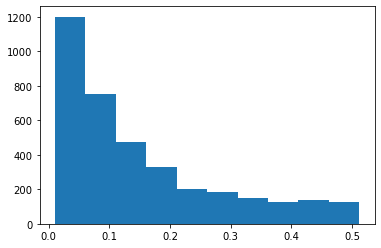

In [7]:
plt.hist(ref.mean('strain'))

In [8]:
# TODO: Decide if I want to discretize here.
ref_dist = ref.discretized().pdist()
fit_dist = fit_genotypes.discretized().pdist()

In [9]:
dedup_thresh = 0.05  # / distance_proportionality

ref_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(ref_dist),
    index=ref_dist.columns,
)
fit_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

ref_clust.value_counts()

20     15
11      8
21      7
42      6
54      6
       ..
348     1
351     1
352     1
354     1
751     1
Length: 752, dtype: int64

In [10]:
fit_clust.value_counts().sort_values(ascending=False).head()

0     1
24    1
23    1
2     1
3     1
dtype: int64

In [11]:
ref_dedup = sf.Genotypes(ref.to_series().unstack('strain').groupby(ref_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())
fit_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

In [12]:
(ref.sizes['strain'], ref_dedup.sizes['strain']), (fit_genotypes.sizes['strain'], fit_dedup.sizes['strain'])

((1000, 752), (198, 198))

In [13]:
from scipy.spatial.distance import pdist, squareform

g = sf.data.Genotypes.concat(dict(
    ref=ref_dedup,
    fit=fit_dedup,
), dim='strain')

dist = pd.DataFrame(g.discretized().pdist(), index=g.strain, columns=g.strain)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


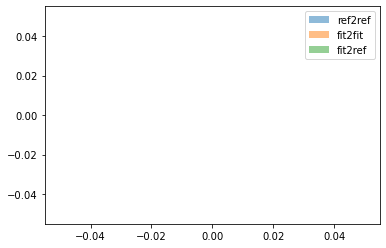

In [14]:
d = dist.loc[
        lambda x: x.index.str.startswith('ref_'),
        lambda x: x.columns.str.startswith('ref_')
    ]
min_dist_ref_to_ref = (d + np.eye(len(d))).min()

d = dist.loc[
        lambda x: x.index.str.startswith('fit_'),
        lambda x: x.columns.str.startswith('fit_')
    ]
min_dist_fit_to_fit = (d + np.eye(len(d))).min()

min_dist_fit_to_ref = dist.loc[
    lambda x: x.index.str.startswith('ref_'),
    lambda x: x.columns.str.startswith('fit_')
].min()

bins = np.linspace(0, 0.03, num=31)



plt.hist(
    min_dist_ref_to_ref,  # * distance_proportionality,
    bins=bins,
    alpha=0.5,
    density=True,
    label='ref2ref',
)
plt.hist(
    min_dist_fit_to_fit, # * distance_proportionality,
    bins=bins,
    alpha=0.5,
    density=True,
    label='fit2fit',
)
plt.hist(
    min_dist_fit_to_ref, # * distance_proportionality,
    bins=bins,
    alpha=0.5,
    density=True,
    label='fit2ref',
)

plt.legend()


# plt.yscale('log')

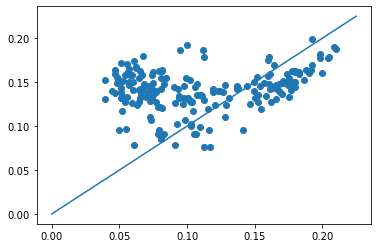

In [15]:
plt.scatter(min_dist_fit_to_ref, min_dist_fit_to_fit)
plt.plot([0, 0.225], [0, 0.225])

In [16]:
sp.stats.wilcoxon(min_dist_fit_to_ref, min_dist_fit_to_fit, alternative='greater')

WilcoxonResult(statistic=4282.5, pvalue=0.9999999999973418)

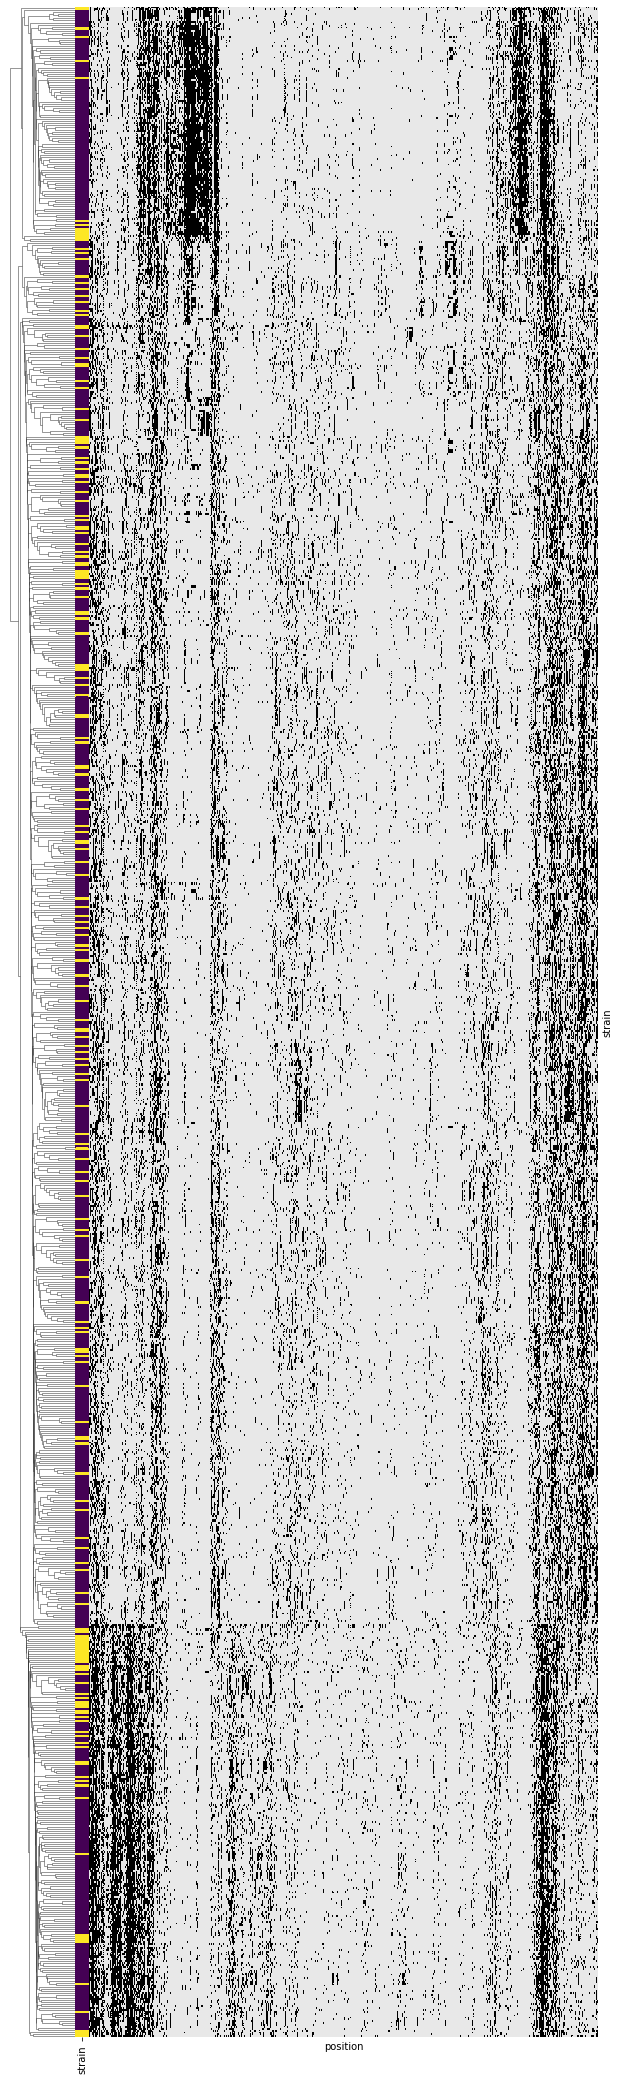

In [17]:
np.random.seed(0)

sf.plot.plot_genotype(
    g.random_sample(position=3500).discretized(),
    row_colors_func=lambda w: w.strain.str.startswith('fit_'),
    row_linkage_func=lambda w: g.discretized().linkage(method='average'),
    scaley=3e-2,
    scalex=2e-3,
    yticklabels=0,
    dheight=0.001,
    cmap='gray_r',
    norm=mpl.colors.PowerNorm(1, vmin=-0.1, vmax=1.),
)

0.15 0.15


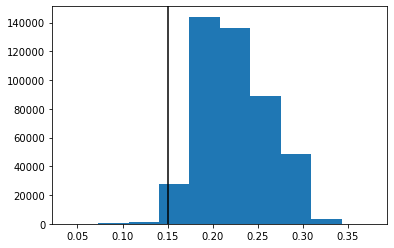

In [18]:
clust_thresh = 0.15  # np.quantile(squareform(dist), 0.1)
print(clust_thresh, clust_thresh) # * distance_proportionality)

plt.hist(squareform(dist))
plt.axvline(clust_thresh, color='k')

In [19]:
all_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=clust_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(dist),
    index=g.strain,
)

clust_type = all_clust.index.to_series().str[:3]

In [20]:
from itertools import product
    
def count_clust_types(clust, key):
    clust_types = (
        clust
        .to_frame(name='clust')
        .assign(key=key)
        .groupby(['clust', 'key'])
        .apply(len)
        .unstack(fill_value=0)
    )
    all_keys = clust_types.columns.to_list()
    all_possible_clust_types = pd.DataFrame(product([True, False], repeat=len(all_keys)), columns=all_keys)
    return clust_types, clust_types.apply(lambda x: x > 0).groupby(all_keys).apply(len).reindex(all_possible_clust_types, fill_value=0)

clust_stats, clust_type_tally = count_clust_types(all_clust, clust_type)

clust_type_tally

fit    ref  
True   True     115
       False     61
False  True     280
       False      0
dtype: int64

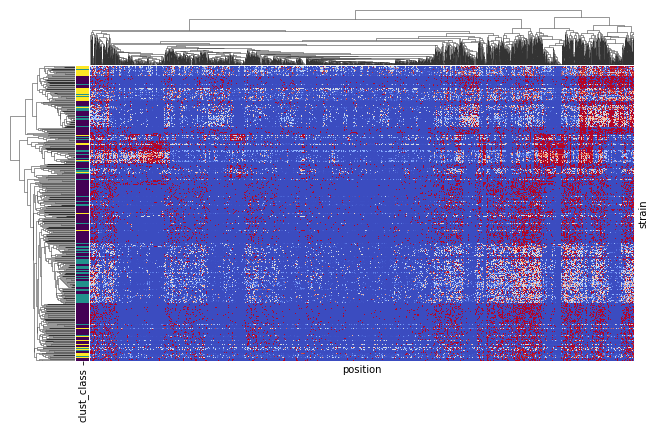

In [21]:
_clust_stats = (
    clust_stats
    .assign(
        tally=lambda x: x.sum(1),
    )
    .assign(only_fit=lambda x: x.ref==0, only_ref=lambda x: x.fit==0)
    .assign(both=lambda x: ~(x.only_fit | x.only_ref))
    .assign(clust_class=lambda x: x[['only_ref', 'both', 'only_fit']].values.argmax(1))
)

clust_genotypes = sf.Genotypes(g.to_series().unstack('strain').groupby(all_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())

sf.plot.plot_genotype(
    clust_genotypes.random_sample(position=2500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].to_xarray(),
    scaley=1e-2,
    scalex=3e-3,
    yticklabels=0
)

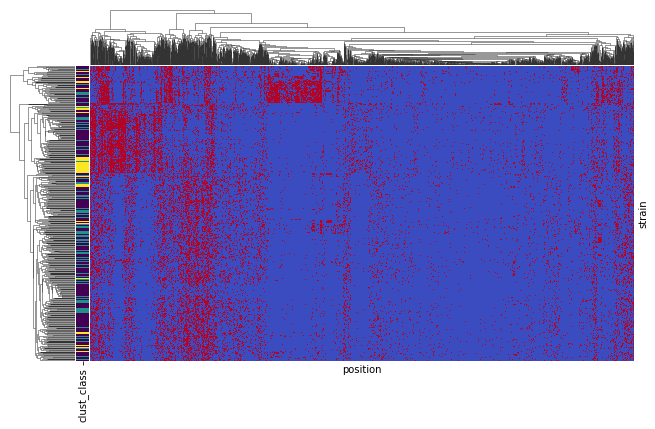

In [22]:
sf.plot.plot_genotype(
    clust_genotypes.discretized().random_sample(position=2500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].to_xarray(),
    scaley=1e-2,
    scalex=3e-3,
    yticklabels=0
)

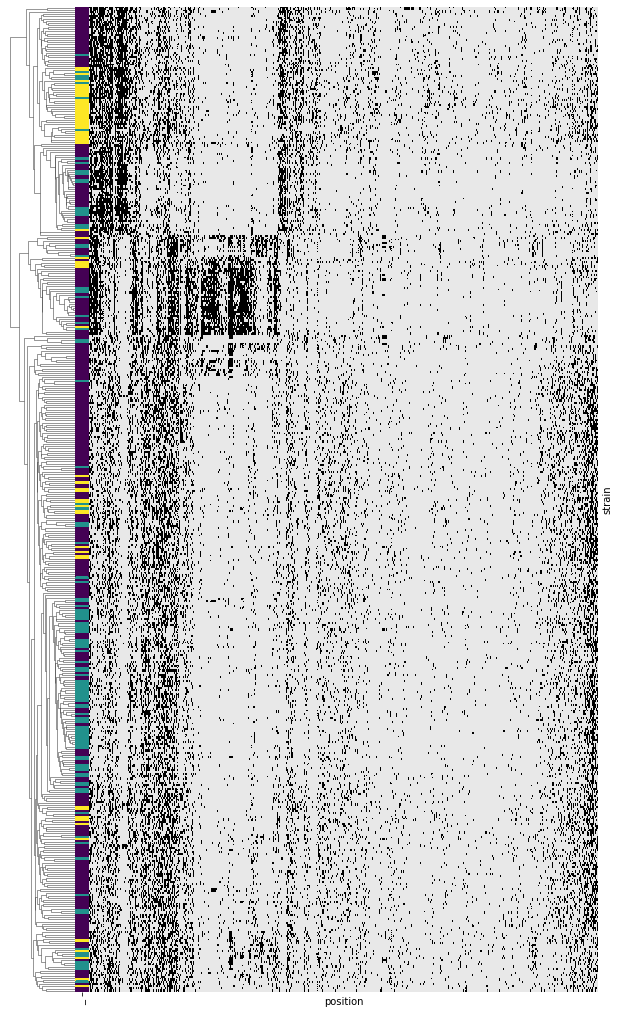

In [23]:
np.random.seed(0)

sf.plot.plot_genotype(
    clust_genotypes.discretized().random_sample(position=3500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].rename(columns={'clust_class': '_'}).to_xarray(),
    row_linkage_func=lambda w: clust_genotypes.linkage(method='complete'),
    scaley=3e-2,
    scalex=2e-3,
    yticklabels=0,
    dheight=0.001,
    cmap='gray_r',
    norm=mpl.colors.PowerNorm(1, vmin=-0.1, vmax=1.),
    rasterized=True,
)

plt.savefig(f'fig/coclustering_{species_id}.pdf', dpi=400)

In [24]:
len(_clust_stats)

456

In [25]:
# Count the number of each type of genotype in each type of cluster.
_clust_stats.groupby(['only_fit', 'both', 'only_ref'])[['fit', 'ref']].sum().apply(lambda x: x / x.sum())

key                           fit       ref
only_fit both  only_ref                    
False    False True      0.000000  0.550532
         True  False     0.686869  0.449468
True     False False     0.313131  0.000000

In [26]:
unmatched_inferred_strains = idxwhere(all_clust.isin(idxwhere(_clust_stats.only_fit)))
print(len(unmatched_inferred_strains))

print(1 - dist.loc[lambda x: x.columns.str.startswith('ref_'), unmatched_inferred_strains].min().mean())  # * distance_proportionality)

62
0.8273742233439371


In [27]:
np.random.seed(0)

def permutation_clust_types(clust, key, n=1, progress=False):
    _, observed = count_clust_types(clust, key)
    permutations = []
    for _ in tqdm(range(n), disable=(not progress)):
        perm_clust = pd.Series(np.random.choice(clust.values, size=len(clust), replace=False), index=clust.index)
        permutations.append(count_clust_types(perm_clust, key)[1])
    return observed, pd.DataFrame(permutations)

obs, perm = permutation_clust_types(all_clust, all_clust.index.to_series().str[:3], n=9999, progress=True)

100%|██████████| 9999/9999 [01:31<00:00, 109.63it/s]


In [28]:
obs.to_frame(name='tally').assign(frac=lambda x: x / x.sum())

tally      frac
fit   ref                   
True  True     115  0.252193
      False     61  0.133772
False True     280  0.614035
      False      0  0.000000

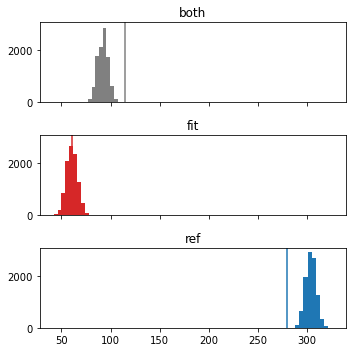

In [29]:
fig, axs = plt.subplots(3, figsize=(5, 5), sharex=True, sharey=True)

for (key, c, label), ax in zip([((True, True), 'grey', 'both'), ((True, False), 'tab:red', 'fit'), ((False, True), 'tab:blue', 'ref')], axs):
    ax.hist(perm[key], color=c)
    ax.axvline(obs[key], color=c, label=label)
    ax.set_title(label)
fig.tight_layout()

In [30]:
def tally_permutation_test(obs, perm):    
    out = {}
    for key in obs.index:
        out[key, '>'] = ((obs[key] > perm[key]).sum())
        out[key, '=='] = ((obs[key] == perm[key]).sum())
        out[key, '<'] = ((obs[key] < perm[key]).sum())
    return pd.Series(out).unstack()

tally_permutation_test(obs, perm).apply(lambda x: x / x.sum(), axis=1)

,<,==,>
"(False, False)",0.000000,1.000000,0.000000
"(False, True)",1.000000,0.000000,0.000000
"(True, False)",0.417442,0.066007,0.516552
"(True, True)",0.000000,0.000000,1.000000


In [31]:
np.random.seed(0)

def permutation_strain_clust_type(clust, key, n=1, progress=False):
    clust_stats, _ = count_clust_types(clust, key)
    observed = clust_stats.groupby((clust_stats > 0).apply(lambda x: tuple(x), axis=1)).sum().stack()
    permutations = []
    for _ in tqdm(range(n), disable=(not progress)):
        perm_clust = pd.Series(np.random.choice(clust.values, size=len(clust), replace=False), index=clust.index)
        perm_clust_stats, _ = count_clust_types(perm_clust, key)
        permutations.append(perm_clust_stats.groupby((perm_clust_stats > 0).apply(lambda x: tuple(x), axis=1)).sum().stack())
    return observed, pd.DataFrame(permutations)

obs2, perm2 = permutation_strain_clust_type(all_clust, all_clust.index.to_series().str[:3], n=9999, progress=True)

100%|██████████| 9999/9999 [02:32<00:00, 65.48it/s]


In [32]:
obs2

               key
(False, True)  fit      0
               ref    414
(True, False)  fit     62
               ref      0
(True, True)   fit    136
               ref    338
dtype: int64

In [33]:
perm2

(False, True)      (True, False)     (True, True)     
key            fit  ref           fit ref          fit  ref
0                0  492            78   0          120  260
1                0  468            66   0          132  284
2                0  489            69   0          129  263
3                0  459            69   0          129  293
4                0  453            53   0          145  299
...            ...  ...           ...  ..          ...  ...
9994             0  457            54   0          144  295
9995             0  454            64   0          134  298
9996             0  442            61   0          137  310
9997             0  442            72   0          126  310
9998             0  436            61   0          137  316

[9999 rows x 6 columns]

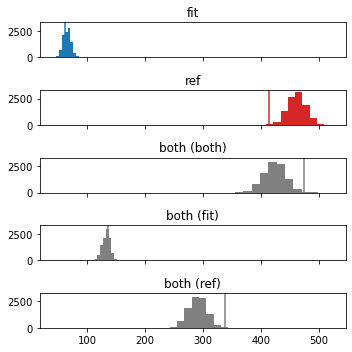

In [34]:
fig, axs = plt.subplots(5, figsize=(5, 5), sharex=True, sharey=True)

for (key, c, label), ax in zip(
    [
        (((True, False), 'fit'), 'tab:blue', 'fit'),
        (((False, True), 'ref'), 'tab:red', 'ref'),
    ],
    axs
):
    ax.hist(perm2[key], color=c)
    ax.axvline(obs2[key], color=c, label=label)
    ax.set_title(label)
    
    

ax = axs[2]
c = 'grey'
ax.hist(perm2[((True, True), 'fit')] + perm2[((True, True), 'ref')], color=c)
ax.axvline(obs2[((True, True), 'fit')] + obs2[((True, True), 'ref')], c=c)
ax.set_title('both (both)')

ax = axs[3]
c = 'grey'
ax.hist(perm2[((True, True), 'fit')], color=c)
ax.axvline(obs2[((True, True), 'fit')], c=c)
ax.set_title('both (fit)')

ax = axs[4]
c = 'grey'
ax.hist(perm2[((True, True), 'ref')], color=c)
ax.axvline(obs2[((True, True), 'ref')], c=c)
ax.set_title('both (ref)')

fig.tight_layout()

In [35]:
(
    (perm2[((True, True), 'fit')] + perm2[((True, True), 'ref')])
    >=
    (obs2[((True, True), 'fit')] + obs2[((True, True), 'ref')])
).mean()

0.0022002200220022

In [36]:
(
    obs2[((True, False), 'fit')]
    <=
    perm2[((True, False), 'fit')]    
).mean()

0.7113711371137114